In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob, os
from collections import deque

In [2]:
class Line():
    def __init__(self):
        
        # was the line detected in last fit
        self.detected = False
        
        self.left_fit = None
        self.right_fit = None

        self.leftx_base = None
        self.rightx_base = None

In [3]:
def calibrate_camera(nx = 9, ny = 6):
    """
     This functions calibrate the camera with chess board method.
     
     1. Read all the images from camera_cal
     2. Convert to gray scale
     3. find the chess board corners
     4. append the points in image points
     5. calibrate the camera and return mtx and dist
    """
    
    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.
    
    # Prepare object point
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    # load all the images via glob
    images = glob.glob('camera_cal/calibration*.jpg')
    
    for image_name in images:
        
        # read the image
        img = cv2.imread(image_name)
        
        # Convert to gray scale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
        # if ret is true, add object points
        if ret == True:
            # add image points and object point.
            imgpoints.append(corners)
            objpoints.append(objp)
        else:
            print('unable to find the corners for image - ', image_name)
    
    # Calibrate the camera and return the mtx and dist
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return (mtx, dist)


def undistort_image(img, mtx, dist):
    """
    This function takes in image, mtx and dist and undistort the image.
    """
    # undistort the image
    return cv2.undistort(img, mtx, dist, None, mtx)

In [4]:
def abs_sobel_thresh(img, orient='x', thresh =(0,255)):
    """
    This function applys sobel threshold and return a binary image
    """
    
    # take the derivative in x or y given orient
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # mask of 1's where the scaled gradient magnitude
    # is >= thresh_min and <= thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # Return the binary image
    return grad_binary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    This function applies Sobel x and y,
    then compute the magnitude of the gradient
    then applies a threshold and return binary output
    """
    # Take the gradient of x and y
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2) 
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # Create a binary mask
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    # Return the binary image
    return mag_binary


def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    """
    This function defines the sobel x and y
    Then computes the direction of the gradient and apply a threshold
    """
    
    # Take the gradient of x and y
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Calculate the gradient direction
    grad_dir = np.arctan2(abs_sobelx, abs_sobely)
    
    # Create a binary mask
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= dir_thresh[0]) & (grad_dir <= dir_thresh[1])] = 1
    
    # Return the binary image
    return dir_binary

def color_threshold(img):
    
    """
    This function returns a binary color threshold. It uses min max for white
    and yellow mask and then return a filtered binary output.
    """
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # mask for yellow
    yellow_min = np.array([15, 100, 120], np.uint8)
    yellow_max = np.array([80, 255, 255], np.uint8)
    yellow_mask = cv2.inRange(img, yellow_min, yellow_max)

    # mask for white
    white_min = np.array([0, 0, 200], np.uint8)
    white_max = np.array([255, 30, 255], np.uint8)
    white_mask = cv2.inRange(img, white_min, white_max)

    binary_output = np.zeros_like(img[:, :, 0])
    binary_output[((yellow_mask != 0) | (white_mask != 0))] = 1

    filtered = img
    filtered[((yellow_mask == 0) & (white_mask == 0))] = 0

    return binary_output

In [5]:
def combined_color_pipeline(img, sobel_thresh=(20, 100), color_thresh=(170, 255)):
    """
    This function combines Sobel X and apply color thresholding
    and return combined binary
    """
    
    # HLS and color threshold
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:, :, 2]
    
    # Covert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel X
    sxbinary = abs_sobel_thresh(gray, orient='x', thresh=sobel_thresh)
    
    # Color Channel
    s_binary = color_threshold(img)

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

In [6]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [7]:
def image_warper(img, src_points, dest_points):
    """
    This function calculates the perspective transform.
    """
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    
    # Calculate the perspective transform
    M = cv2.getPerspectiveTransform(src_points, dest_points)
    
    # Wrap the image using open cv wrapPerspective
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped

def image_De_warper(img, src_points, dest_points):
    """
    This function calculates the perspective transform.
    """
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    
    # Calculate the perspective transform
    M = cv2.getPerspectiveTransform(dest_points, src_points)
    
    # Wrap the image using open cv wrapPerspective
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped

In [8]:
def find_lane_pixels(binary_warped):
    """
    This function find the lane pixels
    """
    global g_line
    
    # Bottom half of the image
    bottom_half = binary_warped[binary_warped.shape[0]//2:,:]

    # Take the histogram
    histogram = np.sum(bottom_half, axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    g_line.leftx_base = np.argmax(histogram[:midpoint])
    g_line.rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = g_line.leftx_base
    rightx_current = g_line.rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


def fit_lane_lines(binary_warped):
    """
    This function fit the lane lines.
    """
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    g_line.left_fit = left_fit
    g_line.right_fit = right_fit
    g_line.detected = True
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fitx, right_fitx, ploty


In [9]:
def search_previous_fitted_lane_lines(binary_warped):
    """
    This function searches for the previously fitted line.
    """
    
    global g_line
    
    # Width of the margin around the previous polynomial to search
    margin = 100
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (g_line.left_fit[0] * (nonzeroy ** 2) + g_line.left_fit[1] * nonzeroy + g_line.left_fit[2] - margin)) & (
    nonzerox < (g_line.left_fit[0] * (nonzeroy ** 2) + g_line.left_fit[1] * nonzeroy + g_line.left_fit[2] + margin)))
    
    right_lane_inds = ((nonzerox > (g_line.right_fit[0] * (nonzeroy ** 2) + g_line.right_fit[1] * nonzeroy + g_line.right_fit[2] - margin)) & (
    nonzerox < (g_line.right_fit[0] * (nonzeroy ** 2) + g_line.right_fit[1] * nonzeroy + g_line.right_fit[2] + margin)))
    
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Setting the g_line for fit
    g_line.left_fit = left_fit
    g_line.right_fit = right_fit
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    #Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty
    

In [10]:
# Calibrate Camera
mtx, dist = calibrate_camera()

unable to find the corners for image -  camera_cal\calibration1.jpg
unable to find the corners for image -  camera_cal\calibration4.jpg
unable to find the corners for image -  camera_cal\calibration5.jpg


In [12]:
# Source and destination points image warper
src_points = np.float32([[250, 680],
        [1050, 680],
        [590, 455],
        [695, 455]
    ])

dst_points = np.float32([[320, 680],
        [950, 680],
        [320, 0],
        [950, 0]
    ])


In [13]:
def calculate_vehicle_position(binary_warped):
    """
    This function calculates the vehicle position.
    """
    global  g_line
    xm_per_pix = 3.7 / 650
    left_line_x = g_line.left_fit[0] * binary_warped.shape[0] ** 2 + g_line.left_fit[1] * binary_warped.shape[0] + \
                     g_line.left_fit[2]
    right_line_x = g_line.right_fit[0] * binary_warped.shape[0] ** 2 + g_line.right_fit[1] * binary_warped.shape[0] + \
                      g_line.right_fit[2]

    vehicle_deviation = ((left_line_x + right_line_x) / 2.0) - (binary_warped.shape[1] / 2.0)
    return vehicle_deviation * xm_per_pix

def calculate_radius(binary_warped, left_fitx, right_fitx):
    """
    This function calculates the radius
    """
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/650 # meters per pixel in x dimension

    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    y_eval = 720
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])

    return (left_curverad, right_curverad)

In [14]:
def process_image(img):
    """
    This is the main function for the processing image. The steps that are as follows: 
    
    1. Undistort the image
    2. Apply Sobel x and color thresholding
    3. Apply Region of interest
    4. Warp the perspective transform
    5. Check for previously fitted line
    6. If found, return the fitted line
    7. If not found, then fit the lane line
    8. Generate a Polygon
    9. Draw the lanes
    
    """
    
    global g_line
    
    # Undistort image
    image = undistort_image(img, mtx, dist)
    
    # Thesholding Pipeline
    combined_binary = combined_color_pipeline(image)
    
    # Height and width of combined binary
    img_width = combined_binary.shape[1]
    img_height = combined_binary.shape[0]
    
    vertices = np.array([[(0, img_height),  # bottom left
                          (img_width * 0.47, img_height * 0.60),  # top left
                          (img_width * 0.53, img_height * 0.60),  # top right
                          (img_width, img_height)]], dtype=np.int32)  # bottom right
    
    binary_masked_img = region_of_interest(combined_binary, vertices)
    
    # Binary warper
    warped_binary = image_warper(binary_masked_img, src_points, dst_points)
    
    #Lane Detection
    if g_line.detected:
        # detect new fit line
        left_fitx, right_fitx, ploty = search_previous_fitted_lane_lines(warped_binary)
    else:
        left_fitx, right_fitx, ploty = fit_lane_lines(warped_binary)

    # Generate a polygon to illustrate the search window area
    left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    binary_warped_zero = np.zeros_like(warped_binary).astype(np.uint8)

    lanes_warped = np.dstack((binary_warped_zero, binary_warped_zero, binary_warped_zero))
    lane_pts = np.hstack((left_line_pts, right_line_pts))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(lanes_warped, np.int_([lane_pts]), (0, 255, 0))
    
    # Combine the result with the original image
    unwarped_result = cv2.addWeighted(image, 1, image_De_warper(lanes_warped, src_points, dst_points), 0.3, 0)
    
    vehicle_deviation = calculate_vehicle_position(warped_binary)
    left_curvature, right_curvature  = calculate_radius(warped_binary, left_fitx, right_fitx)

    cv2.putText(unwarped_result, 'Vehicle Lane Deviation in m: {:06.3f}'.format(vehicle_deviation), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (200,255,155), 2, cv2.LINE_8)

    cv2.putText(unwarped_result, 'Curvature in m: Left {:06.2f}'.format(left_curvature), (50, 100),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (200, 255, 155), 2, cv2.LINE_8)

    cv2.putText(unwarped_result,
                'Right {:06.2f}'.format(right_curvature), (50, 150),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (200, 255, 155), 2, cv2.LINE_8)

    return unwarped_result
    

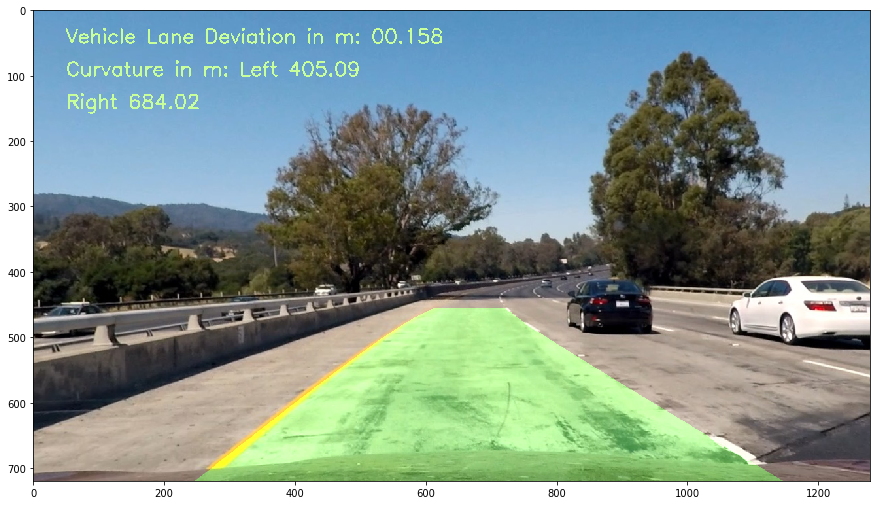

In [15]:
g_line = Line()
img = cv2.imread("./test_images/test1.jpg")
test5 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out = process_image(test5)

fig = plt.gcf()
fig.set_size_inches(15, 20)
plt.imshow(out)

In [16]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

g_line = Line()
output_vid = 'project_video_output.mp4'
input_clip = VideoFileClip('project_video.mp4')
#small_clip = VideoFileClip('project_video.mp4').subclip(10,15)
processed_clip = input_clip.fl_image(process_image) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(output_vid, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:33<00:00,  4.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min 35s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_vid))